In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
process_type='intra'

species='mouse'
SRP_name='aggregates'
resolution='1kbp_raw'

In [4]:
base_folder='/grid/gillis/data_norepl/lohia'

In [ ]:
"/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/"

In [51]:
df = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/1kbp_raw/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [11]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [1000]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [12]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list[['gene', 'group', 'cell_type', 'recurrence', 'n_datasets', 'rank', 'auroc']].merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        #marker_list = pd.concat([marker_list, marker_list_tmp])
        
        #bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        #marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            #df2_list.append(m_tmp[m_tmp['recurrence'] >=1])
            
            #df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


                gene       group   cell_type  recurrence  n_datasets  rank  \
0      6530403H02Rik     L2/3 IT   L2/3 IT_1           5           6     1   
1            Adamts2     L2/3 IT   L2/3 IT_1           5           6     2   
2            Col23a1     L2/3 IT   L2/3 IT_1           5           6     3   
3                Met     L2/3 IT   L2/3 IT_1           5           6     4   
4                Ust     L2/3 IT   L2/3 IT_1           5           6     5   
...              ...         ...         ...         ...         ...   ...   
11995         Gpcpd1  L6 IT Car3  L6 IT Car3           0           4   996   
11996          Nfat5  L6 IT Car3  L6 IT Car3           0           4   997   
11997          Lamp2  L6 IT Car3  L6 IT Car3           0           4   998   
11998         Cacnb1  L6 IT Car3  L6 IT Car3           0           4   999   
11999        Pitpnm2  L6 IT Car3  L6 IT Car3           0           4  1000   

          auroc         classt  fold_change  fold_change_detect

In [13]:
cat_list_genes = marker_table.index.tolist()

In [15]:
len(cat_list_genes)

15753

In [16]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [17]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [18]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list[['gene', 'group', 'cell_type', 'recurrence', 'n_datasets', 'rank', 'auroc']].merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        #marker_list = pd.concat([marker_list, marker_list_tmp])
        
        #bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        #marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp[m_tmp['recurrence'] >=1])
            
            #df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            #df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


                gene       group   cell_type  recurrence  n_datasets  rank  \
0      6530403H02Rik     L2/3 IT   L2/3 IT_1           5           6     1   
1            Adamts2     L2/3 IT   L2/3 IT_1           5           6     2   
2            Col23a1     L2/3 IT   L2/3 IT_1           5           6     3   
3                Met     L2/3 IT   L2/3 IT_1           5           6     4   
4                Ust     L2/3 IT   L2/3 IT_1           5           6     5   
...              ...         ...         ...         ...         ...   ...   
11995         Gpcpd1  L6 IT Car3  L6 IT Car3           0           4   996   
11996          Nfat5  L6 IT Car3  L6 IT Car3           0           4   997   
11997          Lamp2  L6 IT Car3  L6 IT Car3           0           4   998   
11998         Cacnb1  L6 IT Car3  L6 IT Car3           0           4   999   
11999        Pitpnm2  L6 IT Car3  L6 IT Car3           0           4  1000   

          auroc         classt  fold_change  fold_change_detect

In [19]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [20]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]


#df_gene_tp = df_gene_tp.fillna(0)

In [21]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

In [22]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [23]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



In [31]:
blacklist_bins = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_bin_blacklist_10kb.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])


In [32]:
pure_bins = list(set(dk.columns.tolist()) - set(blacklist_bins['bin_id'].tolist()))

In [200]:
dk_max = dk.loc[:, pure_bins].max(axis=0)

In [232]:
dk_max = features_sc_df.T.max(axis=0)

In [229]:
features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)



In [33]:
features.dropna()

0         1         2         3         4        \
classt        group                                                          
GABAergic     Lamp5      -0.076299 -0.076299 -0.076299 -0.076299 -0.076299   
              Pvalb      -0.069176 -0.069176 -0.069176 -0.069176 -0.069176   
              Sncg       -0.079225 -0.079225 -0.079225 -0.079225 -0.079225   
              Sst        -0.075480 -0.075480 -0.075480 -0.075480 -0.075480   
              Sst Chodl  -0.076234 -0.076234 -0.076234 -0.076234 -0.076234   
              Vip        -0.072814 -0.072814 -0.072814 -0.072814 -0.072814   
Glutamatergic L5 PT      -0.072823 -0.072823 -0.072823 -0.072823 -0.072823   
              L5/6 NP    -0.063531 -0.063531 -0.063531 -0.063531 -0.063531   
              L6 CT      -0.076122 -0.076122 -0.076122 -0.076122 -0.076122   
              L6 IT Car3 -0.080956 -0.080956 -0.080956 -0.080956 -0.080956   
              L6b        -0.074339 -0.074339 -0.074339 -0.074339 -0.074339   
Other         Astro      -0.082247 -0.082247 -0.082247 -0.082247 -0.082247   
              Endo       -0.078626 -0.078626 -0.078626 -0.078626 -0.078626   
              Meis2      -0.053908 -0.053908 -0.053908 -0.053908 -0.053908   
              Micro-PVM  -0.077077 -0.077077 -0.077077 -0.077077 -0.077077   
              Oligo      -0.072621 -0.072621 -0.072621 -0.072621 -0.072621   
              Peri       -0.072153 -0.072153 -0.072153 -0.072153 -0.072153   
              SMC        -0.078838 -0.078838 -0.078838 -0.078838 -0.078838   
              VLMC       -0.081331 -0.081331 -0.081331 -0.081331 -0.081331   

                           5         6         7         8         9        \
classt        group                                                          
GABAergic     Lamp5      -0.076299 -0.076299 -0.076299 -0.076299 -0.076299   
              Pvalb      -0.069176 -0.069176 -0.069176 -0.069176 -0.069176   
              Sncg       -0.079225 -0.079225 -0.079225 -0.079225 -0.079225   
              Sst        -0.075480 -0.075480 -0.075480 -0.075480 -0.075480   
              Sst Chodl  -0.076234 -0.076234 -0.076234 -0.076234 -0.076234   
              Vip        -0.072814 -0.072814 -0.072814 -0.072814 -0.072814   
Glutamatergic L5 PT      -0.072823 -0.072823 -0.072823 -0.072823 -0.072823   
              L5/6 NP    -0.063531 -0.063531 -0.063531 -0.063531 -0.063531   
              L6 CT      -0.076122 -0.076122 -0.076122 -0.076122 -0.076122   
              L6 IT Car3 -0.080956 -0.080956 -0.080956 -0.080956 -0.080956   
              L6b        -0.074339 -0.074339 -0.074339 -0.074339 -0.074339   
Other         Astro      -0.082247 -0.082247 -0.082247 -0.082247 -0.082247   
              Endo       -0.078626 -0.078626 -0.078626 -0.078626 -0.078626   
              Meis2      -0.053908 -0.053908 -0.053908 -0.053908 -0.053908   
              Micro-PVM  -0.077077 -0.077077 -0.077077 -0.077077 -0.077077   
              Oligo      -0.072621 -0.072621 -0.072621 -0.072621 -0.072621   
              Peri       -0.072153 -0.072153 -0.072153 -0.072153 -0.072153   
              SMC        -0.078838 -0.078838 -0.078838 -0.078838 -0.078838   
              VLMC       -0.081331 -0.081331 -0.081331 -0.081331 -0.081331   

                          ...   2462745   2462746   2462747   2462748  \
classt        group       ...                                           
GABAergic     Lamp5       ... -0.071154 -0.071154 -0.071154 -0.071154   
              Pvalb       ... -0.082950 -0.082950 -0.082950 -0.082950   
              Sncg        ... -0.099461 -0.099461 -0.099461 -0.099461   
              Sst         ... -0.088566 -0.088566 -0.088566 -0.088566   
              Sst Chodl   ... -0.081466 -0.081466 -0.081466 -0.081466   
              Vip         ... -0.080628 -0.080628 -0.080628 -0.080628   
Glutamatergic L5 PT       ... -0.085595 -0.085595 -0.085595 -0.085595   
              L5/6 NP     ... -0.117416 -0.117416 -0.117416 -0.117416   
              L6 CT

In [34]:
features.dropna(axis=1)

195472    195473    195474    195475    195476   \
classt        group                                                          
GABAergic     Lamp5      -0.075818 -0.075818 -0.075818 -0.075818 -0.075818   
              Pvalb      -0.083063 -0.083063 -0.083063 -0.083063 -0.083063   
              Sncg       -0.082570 -0.082570 -0.082570 -0.082570 -0.082570   
              Sst        -0.074078 -0.074078 -0.074078 -0.074078 -0.074078   
              Sst Chodl  -0.077942 -0.077942 -0.077942 -0.077942 -0.077942   
              Vip        -0.081019 -0.081019 -0.081019 -0.081019 -0.081019   
Glutamatergic L2/3 IT    -0.083115 -0.083115 -0.083115 -0.083115 -0.083115   
              L4/5 IT    -0.093591 -0.093591 -0.093591 -0.093591 -0.093591   
              L5 ET      -0.069562 -0.069562 -0.069562 -0.069562 -0.069562   
              L5 IT      -0.080921 -0.080921 -0.080921 -0.080921 -0.080921   
              L5 PT      -0.066603 -0.066603 -0.066603 -0.066603 -0.066603   
              L5/6 NP    -0.078855 -0.078855 -0.078855 -0.078855 -0.078855   
              L6 CT      -0.077855 -0.077855 -0.077855 -0.077855 -0.077855   
              L6 IT      -0.076979 -0.076979 -0.076979 -0.076979 -0.076979   
              L6 IT Car3 -0.065748 -0.065748 -0.065748 -0.065748 -0.065748   
              L6b        -0.069626 -0.069626 -0.069626 -0.069626 -0.069626   
Other         Astro      -0.075849 -0.075849 -0.075849 -0.075849 -0.075849   
              Endo       -0.073663 -0.073663 -0.073663 -0.073663 -0.073663   
              Meis2      -0.071469 -0.071469 -0.071469 -0.071469 -0.071469   
              Micro-PVM  -0.075621 -0.075621 -0.075621 -0.075621 -0.075621   
              Oligo      -0.078214 -0.078214 -0.078214 -0.078214 -0.078214   
              Peri       -0.075173 -0.075173 -0.075173 -0.075173 -0.075173   
              SMC        -0.073854 -0.073854 -0.073854 -0.073854 -0.073854   
              VLMC       -0.079281 -0.079281 -0.079281 -0.079281 -0.079281   

                           195477    195478    195479    195480    195481   \
classt        group                                                          
GABAergic     Lamp5      -0.075818 -0.075818 -0.075818 -0.075818 -0.075818   
              Pvalb      -0.083063 -0.083063 -0.083063 -0.083063 -0.083063   
              Sncg       -0.082570 -0.082570 -0.082570 -0.082570 -0.082570   
              Sst        -0.074078 -0.074078 -0.074078 -0.074078 -0.074078   
              Sst Chodl  -0.077942 -0.077942 -0.077942 -0.077942 -0.077942   
              Vip        -0.081019 -0.081019 -0.081019 -0.081019 -0.081019   
Glutamatergic L2/3 IT    -0.083115 -0.083115 -0.083115 -0.083115 -0.083115   
              L4/5 IT    -0.093591 -0.093591 -0.093591 -0.093591 -0.093591   
              L5 ET      -0.069562 -0.069562 -0.069562 -0.069562 -0.069562   
              L5 IT      -0.080921 -0.080921 -0.080921 -0.080921 -0.080921   
              L5 PT      -0.066603 -0.066603 -0.066603 -0.066603 -0.066603   
              L5/6 NP    -0.078855 -0.078855 -0.078855 -0.078855 -0.078855   
              L6 CT      -0.077855 -0.077855 -0.077855 -0.077855 -0.077855   
              L6 IT      -0.076979 -0.076979 -0.076979 -0.076979 -0.076979   
              L6 IT Car3 -0.065748 -0.065748 -0.065748 -0.065748 -0.065748   
              L6b        -0.069626 -0.069626 -0.069626 -0.069626 -0.069626   
Other         Astro      -0.075849 -0.075849 -0.075849 -0.075849 -0.075849   
              Endo       -0.073663 -0.073663 -0.073663 -0.073663 -0.073663   
              Meis2      -0.071469 -0.071469 -0.071469 -0.071469 -0.071469   
              Micro-PVM  -0.075621 -0.075621 -0.075621 -0.075621 -0.075621   
              Oligo      -0.078214 -0.078214 -0.078214 -0.078214 -0.078214   
              Peri       -0.075173 -0.075173 -0.075173 -0.075173 -0.075173   
              SMC        -0.073854 -0.073854 -0.073854 -0.073854 -0.073854   
              VLMC       -0.079281 -0.079281 -0.

<ipython-input-35-c7b68ddb351f>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


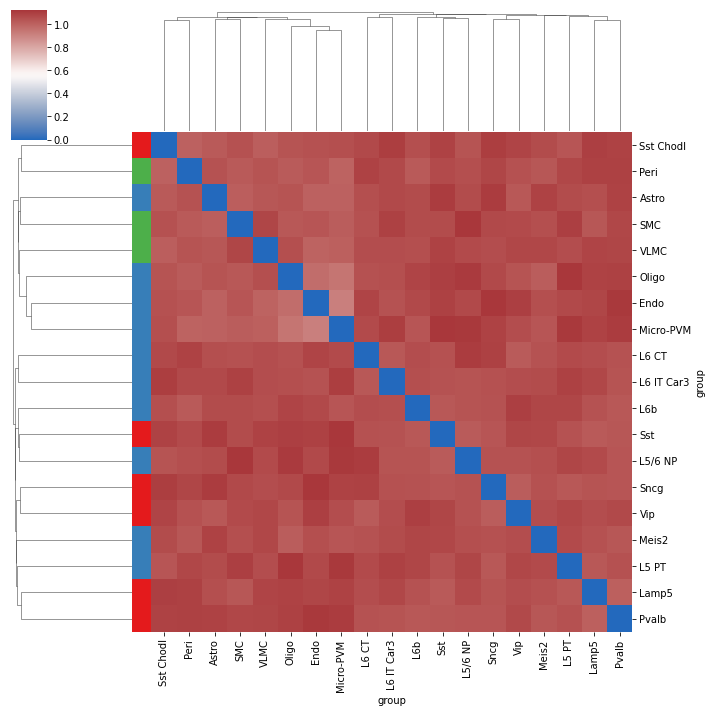

In [35]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]

#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-36-b2976ebda22b>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


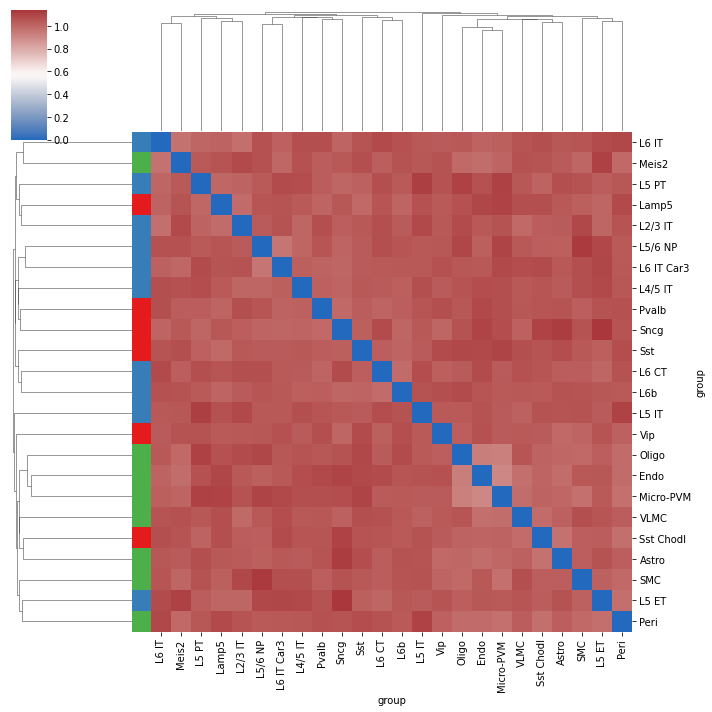

In [36]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]

#features = dk.loc[:, :]
features = features.dropna(axis=1)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [26]:
df_dist

array([[0.        , 0.99278204, 1.03118278, 1.01823745, 1.07802469,
        1.0507918 ,        nan,        nan,        nan,        nan,
        1.00307118, 1.05508219, 1.05395357,        nan, 1.06278439,
        1.03829793, 1.04363366, 1.05903347, 1.04188566, 1.07657807,
        1.07457837, 1.08031254, 1.01386662, 1.07413807],
       [0.99278204, 0.        , 1.01476276, 1.02487948, 1.07437612,
        1.05671959,        nan,        nan,        nan,        nan,
        1.03951676, 1.02687623, 1.02804704,        nan, 1.03125627,
        1.01144187, 1.07771933, 1.090682  , 1.03682735, 1.08368872,
        1.0688588 , 1.07373114, 1.05329589, 1.06284016],
       [1.03118278, 1.01476276, 0.        , 1.03146128, 1.07536348,
        1.00972888,        nan,        nan,        nan,        nan,
        1.01220673, 1.0321338 , 1.06697059,        nan, 1.04166747,
        1.03157173, 1.0770549 , 1.10837008, 1.03720239, 1.0591853 ,
        1.05214815, 1.04388138, 1.04800783, 1.0268874 ],
       [1.018

In [27]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<ipython-input-167-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


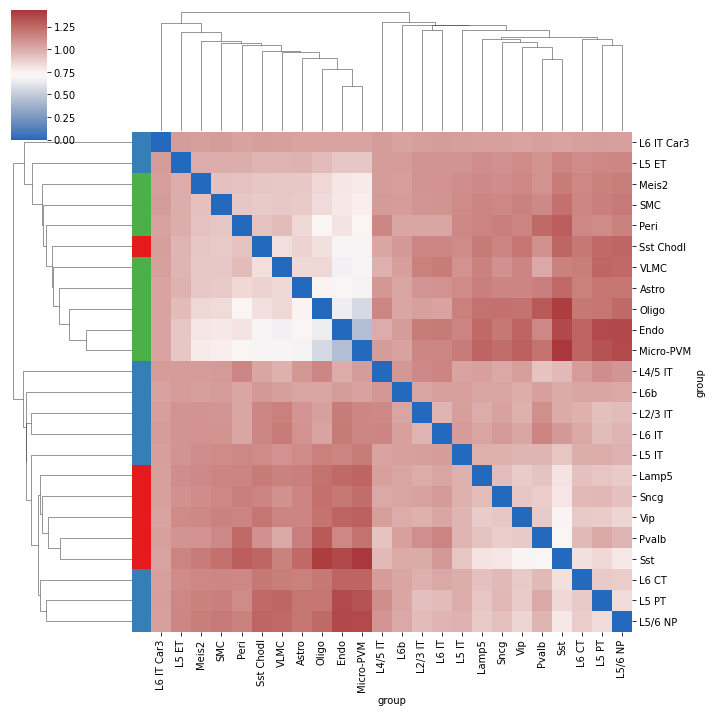

In [167]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-161-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


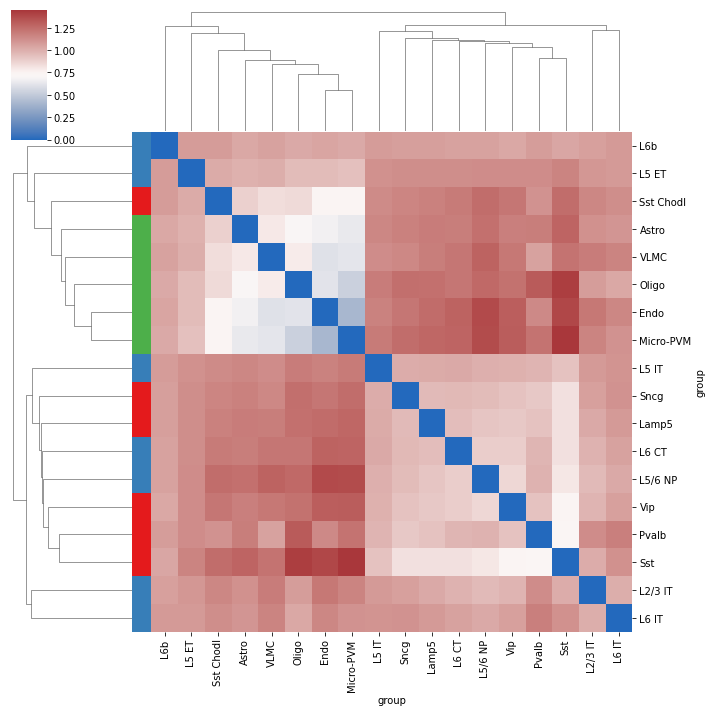

In [161]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-155-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


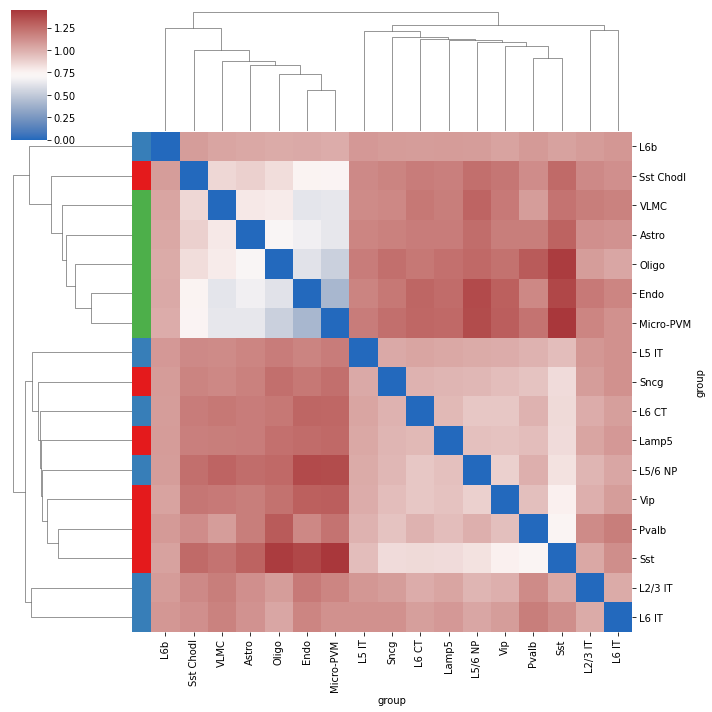

In [155]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [147]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otherr']
dk = dj.groupby(['group']).mean()




features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



KeyError: 'Requested level (classt) does not match index name (group)'

In [37]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['group']).mean()
features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

In [44]:
dk.mean(axis=0)

0         -0.072808
1         -0.072808
2         -0.072808
3         -0.072808
4         -0.072808
             ...   
2462750   -0.085667
2462751   -0.085667
2462752   -0.085667
2462753   -0.085667
2462754   -0.085667
Length: 2462755, dtype: float32

In [38]:
df_all_peak = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_atac_peak_10kb.bed', sep='\t', names=['chrd', 'bin_st', 'bin_end', 'bin_id', 'chr', 'start', 'end', 'peak', 'overlap'])


df_all_peak = df_all_peak[df_all_peak['overlap'] >= 250]


features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)


In [39]:
given_group='L5 ET'

In [40]:
dj = features.T[given_group].reset_index()

dj['spec'] = features_sc_df[given_group].tolist()

#dj = dj.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'L5 ET', 'overlap'], ascending=False).drop_duplicates('peak')


dj = dj.sort_values(by=['spec', given_group], ascending=False)


dj['rank'] = list(range(1,dj.shape[0]+1))

In [41]:
dj[dj['index'].isin([38828,1490431, 2354500])]

index     L5 ET      spec     rank
1419298  1490431 -0.000902 -0.079116   637128
2222104  2354500 -0.033104 -0.097629   656793
38632      38828       NaN       NaN  1938474

In [373]:
df_all_peak = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_atac_peak_10kb.bed', sep='\t', names=['chrd', 'bin_st', 'bin_end', 'bin_id', 'chr', 'start', 'end', 'peak', 'overlap'])


In [374]:
features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)



In [315]:
bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()


In [316]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(100000))
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(100000))


In [347]:
dt

index      VLMC      spec   chrd     bin_st    bin_end   bin_id  \
447228  1374180  4.452042  4.783367   chr9  103629000  103630000  1374180   
452455  1383472  3.247307  4.759694   chr9  112921000  112922000  1383472   
325181  1026765  5.339619  4.755317   chr7   31058000   31059000  1026765   
321236  1015452  5.011734  4.754962   chr7   19745000   19746000  1015452   
476200  1464744  2.970114  4.746830  chr10   69597000   69598000  1464744   
...         ...       ...       ...    ...        ...        ...      ...   
58136    199855 -0.122844 -2.956349   chr2    4383000    4384000   199855   
657519  2007290  0.352351 -3.044608  chr14  118813000  118814000  2007290   
349653  1104732 -0.141464 -3.054261   chr7  109025000  109026000  1104732   
575129  1731077 -0.074516 -3.065967  chr12   83152000   83153000  1731077   
162703   534284 -0.084696 -3.089825   chr3  156698000  156699000   534284   

          chr      start        end                       peak  overlap  \
447228   chr9  103628599  103629099   chr9:103628599-103629099       99   
452455   chr9  112920610  112921110   chr9:112920610-112921110      110   
325181   chr7   31058244   31058744     chr7:31058244-31058744      500   
321236   chr7   19745170   19745670     chr7:19745170-19745670      500   
476200  chr10   69597807   69598307    chr10:69597807-69598307      193   
...       ...        ...        ...                        ...      ...   
58136    chr2    4383029    4383529       chr2:4383029-4383529      500   
657519  chr14  118813069  118813569  chr14:118813069-118813569      500   
349653   chr7  109025202  109025702   chr7:109025202-109025702      500   
575129  chr12   83152063   83152563    chr12:83152063-83152563      500   
162703   chr3  156698142  156698642   chr3:156698142-156698642      500   

          rank subclass_Bakken_2022  
447228       1                 VLMC  
452455       2                 VLMC  
325181       3                 VLMC  
321236       4                 VLMC  
476200       5                 VLMC  
...        ...                  ...  
58136   600484                 VLMC  
657519  600485                 VLMC  
349653  600486                 VLMC  
575129  600487                 VLMC  
162703  600488                 VLMC  

[600488 rows x 14 columns]

In [ ]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(10000))
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(10000))


In [375]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        #dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'spec', given_group]])
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        #dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'spec', given_group]])


In [378]:
df_all_peak

chrd    bin_st   bin_end   bin_id    chr     start       end  \
0        chr1   3094000   3095000     3094   chr1   3094805   3095305   
1        chr1   3095000   3096000     3095   chr1   3094805   3095305   
2        chr1   3095000   3096000     3095   chr1   3095470   3095970   
3        chr1   3112000   3113000     3112   chr1   3112174   3112674   
4        chr1   3113000   3114000     3113   chr1   3113534   3114034   
...       ...       ...       ...      ...    ...       ...       ...   
809191  chr19  61098000  61099000  2462421  chr19  61097653  61098153   
809192  chr19  61140000  61141000  2462463  chr19  61140637  61141137   
809193  chr19  61141000  61142000  2462464  chr19  61140637  61141137   
809194  chr19  61151000  61152000  2462474  chr19  61151568  61152068   
809195  chr19  61152000  61153000  2462475  chr19  61151568  61152068   

                           peak  overlap  
0          chr1:3094805-3095305      195  
1          chr1:3094805-3095305      305  
2          chr1:3095470-3095970      500  
3          chr1:3112174-3112674      500  
4          chr1:3113534-3114034      466  
...                         ...      ...  
809191  chr19:61097653-61098153      153  
809192  chr19:61140637-61141137      363  
809193  chr19:61140637-61141137      137  
809194  chr19:61151568-61152068      432  
809195  chr19:61151568-61152068       68  

[809196 rows x 9 columns]

In [376]:
df_findal_result = pd.concat(df_result_list)

In [379]:
df_all_peak[df_all_peak['bin_id'].isin([38828,1490431, 2354500])]

chrd    bin_st   bin_end  bin_id   chr     start       end  \
7727  chr1  38828000  38829000   38828  chr1  38828697  38829197   

                        peak  overlap  
7727  chr1:38828697-38829197      303

In [377]:
df_findal_result[df_findal_result['bin_id'].isin([38828,1490431, 2354500])]

chr     start       end subclass_Bakken_2022    rank  bin_id      spec  \
7727  chr1  38828697  38829197            Sst Chodl  421398   38828 -0.517322   
7727  chr1  38828697  38829197                Astro   26619   38828  1.225219   
7727  chr1  38828697  38829197                 Endo   47802   38828  1.234660   
7727  chr1  38828697  38829197              L2/3 IT   36877   38828  1.800968   
7727  chr1  38828697  38829197                L5 ET   37133   38828  1.962152   
7727  chr1  38828697  38829197                L5 IT   57205   38828  1.573347   
7727  chr1  38828697  38829197                  L6b  352391   38828 -0.221955   
7727  chr1  38828697  38829197                L6 CT  275761   38828 -0.039808   
7727  chr1  38828697  38829197                L6 IT  355918   38828 -0.296085   
7727  chr1  38828697  38829197                Lamp5  552902   38828 -1.370085   
7727  chr1  38828697  38829197            Micro-PVM  573024   38828 -1.011500   
7727  chr1  38828697  38829197              L5/6 NP  137002   38828  0.757012   
7727  chr1  38828697  38829197                Oligo  253771   38828  0.380981   
7727  chr1  38828697  38829197                  OPC  253771   38828  0.380981   
7727  chr1  38828697  38829197                Pvalb  444789   38828 -0.888042   
7727  chr1  38828697  38829197                 Sncg  396544   38828 -0.578521   
7727  chr1  38828697  38829197                  Sst  126565   38828  0.393420   
7727  chr1  38828697  38829197                  Vip  580940   38828 -1.292493   
7727  chr1  38828697  38829197                 VLMC  515551   38828 -0.730532   

      Sst Chodl     Astro      Endo  ...     L6 IT     Lamp5  Micro-PVM  \
7727   0.207116       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN  0.328059       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN  0.328714  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...  0.222471       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN  0.147928        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN   0.172816   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   
7727        NaN       NaN       NaN  ...       NaN       NaN        NaN   

       L5/6 NP     Oligo     Pvalb      Sncg       Sst       Vip      VLMC  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7727       NaN       NaN       NaN    

In [ ]:
38828

In [ ]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/mm10-blacklist.v2.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_bin_blacklist_10kb.bed")
          
    

In [335]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wb -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed -b /grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed > /grid/gillis/home/lohia/notebooks_cre_v3/notebooks/labels_bin.bed" ) 



256

In [336]:
f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed'

'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/all_bins_true.bed'

In [338]:
pd.read_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', sep='\t').to_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', index=False, sep='\t')


In [344]:
pd.read_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', sep='\t')

chr10    95284671    95284984
0  chr18    43880294    43880333
1   chr1    38828035    38828660

In [ ]:
seqnames	start	end
chr10	95284671	95284984
chr13	95439224	95439933
chr3	109713162	109713543
chr18	43880294	43880333
chr6	30113402	30113643
chr1	38828035	38828660

In [299]:
df_findal_result[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank']].to_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/lohia_final.csv', index=False)



In [284]:
df_findal_result.drop_duplicates('subclass_Bakken_2022')

chr      start        end subclass_Bakken_2022  rank   bin_id
696492  chr16    4763182    4763682            Sst Chodl     1  2122187
3326     chr1   22977850   22978350                Astro     1    22977
709888  chr16   34967415   34967915                 Endo     1  2152391
44361    chr1  164338341  164338841              L2/3 IT     1   164338
369780   chr8   11807386   11807886                L5 ET     1  1152956
794294  chr19   22941415   22941915                L5 IT     1  2424264
639608  chr14   47172329   47172829                  L6b     1  1935649
485815  chr10   89118453   89118953                L6 CT     1  1484265
425763   chr9   47471490   47471990                L6 IT     1  1318022
201336   chr4  132382223  132382723                Lamp5     1   670008
652531  chr14   79088751   79089251            Micro-PVM     1  1967565
511545  chr11   47380657   47381157              L5/6 NP     1  1573222
604658  chr13   49347435   49347935                Oligo     1  1817402
604658  chr13   49347435   49347935                  OPC     1  1817402
716208  chr16   60059887   60060387                Pvalb     1  2177484
410230   chr8  127201329  127201829                 Sncg     1  1268350
381168   chr8   53695355   53695855                  Sst     1  1194844
447228   chr9  103628599  103629099                  Vip     1  1374180
234502   chr5   64972313   64972813                 VLMC     1   759107

<ipython-input-322-ff7f5f15c38b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


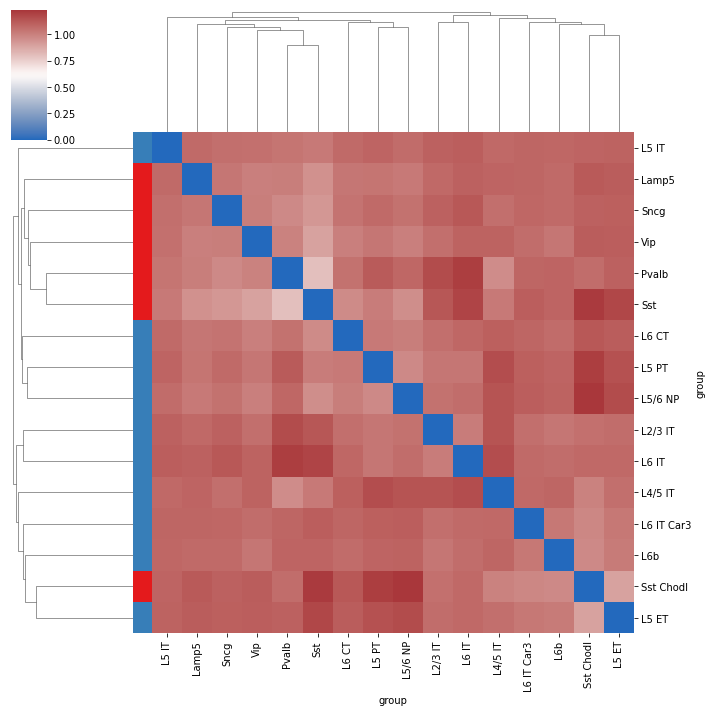

In [322]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
#features = dk.loc[:, df_findal_result['bin_id'].tolist()]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [274]:
df_findal_result.drop_duplicates('subclass_Bakken_2022')

chr      start        end subclass_Bakken_2022  rank   bin_id
696492  chr16    4763182    4763682            Sst Chodl     1  2122187
3326     chr1   22977850   22978350                Astro     1    22977
709888  chr16   34967415   34967915                 Endo     1  2152391
44361    chr1  164338341  164338841              L2/3 IT     1   164338
369780   chr8   11807386   11807886                L5 ET     1  1152956
794294  chr19   22941415   22941915                L5 IT     1  2424264
639608  chr14   47172329   47172829                  L6b     1  1935649
485815  chr10   89118453   89118953                L6 CT     1  1484265
425763   chr9   47471490   47471990                L6 IT     1  1318022
201336   chr4  132382223  132382723                Lamp5     1   670008
652531  chr14   79088751   79089251            Micro-PVM     1  1967565
511545  chr11   47380657   47381157              L5/6 NP     1  1573222
604658  chr13   49347435   49347935                Oligo     1  1817402
716208  chr16   60059887   60060387                Pvalb     1  2177484
410230   chr8  127201329  127201829                 Sncg     1  1268350
381168   chr8   53695355   53695855                  Sst     1  1194844
447228   chr9  103628599  103629099                  Vip     1  1374180
234502   chr5   64972313   64972813                 VLMC     1   759107

In [275]:
bakken_groups

['Sst Chodl',
 'Astro',
 'Endo',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L6b',
 'L6 CT',
 'L6 IT',
 'Lamp5',
 'Micro-PVM',
 'L5/6 NP',
 'Oligo',
 'OPC',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip',
 'VLMC']

In [273]:
df_findal_result[df_findal_result['subclass_Bakken_2022']=='OPC']

Empty DataFrame
Columns: [chr, start, end, subclass_Bakken_2022, rank, bin_id]
Index: []

In [261]:
dt.head(10000)

index  Sst Chodl      spec   chrd     bin_st    bin_end   bin_id  \
696492  2122187   0.483616  4.783942  chr16    4763000    4764000  2122187   
279700   881428   0.346738  4.783623   chr6   35458000   35459000   881428   
167560   563239  -0.081892  4.775377   chr4   25613000   25614000   563239   
764344  2336160   0.327853  4.767207  chr18   25540000   25541000  2336160   
62721    215548  -0.203383  4.766804   chr2   20076000   20077000   215548   
...         ...        ...       ...    ...        ...        ...      ...   
488974  1491782   0.299518  2.009898  chr10   96635000   96636000  1491782   
736959  2246036   0.565072  2.009876  chr17   30404000   30405000  2246036   
539766  1627339   0.560116  2.009808  chr11  101497000  101498000  1627339   
320218  1012725  -0.213626  2.009806   chr7   17018000   17019000  1012725   
466533  1429428   0.203403  2.009803  chr10   34281000   34282000  1429428   

          chr      start        end                       peak  overlap   rank  
696492  chr16    4763182    4763682      chr16:4763182-4763682      500      1  
279700   chr6   35458277   35458777     chr6:35458277-35458777      500      2  
167560   chr4   25613361   25613861     chr4:25613361-25613861      500      3  
764344  chr18   25540434   25540934    chr18:25540434-25540934      500      4  
62721    chr2   20076383   20076883     chr2:20076383-20076883      500      5  
...       ...        ...        ...                        ...      ...    ...  
488974  chr10   96635472   96635972    chr10:96635472-96635972      500   9996  
736959  chr17   30404580   30405080    chr17:30404580-30405080      420   9997  
539766  chr11  101496981  101497481  chr11:101496981-101497481      481   9998  
320218   chr7   17018651   17019151     chr7:17018651-17019151      349   9999  
466533  chr10   34281119   34281619    chr10:34281119-34281619      500  10000  

[10000 rows x 13 columns]

In [123]:
dt = features.T['GABAergic',     'Lamp5'].reset_index()

In [124]:
dt['spec'] = features_sc[0]

In [131]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').columns

Index([         ('index', ''), ('GABAergic', 'Lamp5'),           ('spec', ''),
                       'chrd',               'bin_st',              'bin_end',
                     'bin_id',                  'chr',                'start',
                        'end',                 'peak',              'overlap'],
      dtype='object')

In [139]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=[('spec', ''), ('GABAergic', 'Lamp5'), 'overlap'], ascending=False).drop_duplicates('bin_id')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(index, )  (GABAergic, Lamp5)  (spec, )   chrd     bin_st    bin_end  \
666405    2044772            6.936535  3.312724  chr15   31392000   31393000   
580834    1747274            3.351300  3.312043  chr12   99349000   99350000   
707772    2148423            5.400127  3.311409  chr16   30999000   31000000   
652376    1965988            4.709849  3.310905  chr14   77511000   77512000   
3326        22977            5.948706  3.310401   chr1   22977000   22978000   
...           ...                 ...       ...    ...        ...        ...   
178908     603122           -0.235218 -2.951550   chr4   65496000   65497000   
657965    2007187           -0.135670 -2.966015  chr14  118710000  118711000   
735278    2243265            0.461317 -2.986145  chr17   27633000   27634000   
184139     629042           -0.298038 -3.019186   chr4   91416000   91417000   
608635    1824320            0.165932 -3.061478  chr13   56265000   56266000   

         bin_id    chr      start        end                       peak  \
666405  2044772  chr15   31391966   31392466    chr15:31391966-31392466   
580834  1747274  chr12   99349321   99349821    chr12:99349321-99349821   
707772  2148423  chr16   30998856   30999356    chr16:30998856-30999356   
652376  1965988  chr14   77511409   77511909    chr14:77511409-77511909   
3326      22977   chr1   22977850   22978350     chr1:22977850-22978350   
...         ...    ...        ...        ...                        ...   
178908   603122   chr4   65496370   65496870     chr4:65496370-65496870   
657965  2007187  chr14  118710856  118711356  chr14:118710856-118711356   
735278  2243265  chr17   27633136   27633636    chr17:27633136-27633636   
184139   629042   chr4   91416567   91417067     chr4:91416567-91417067   
608635  1824320  chr13   56265585   56266085    chr13:56265585-56266085   

        overlap  
666405      466  
580834      500  
707772      356  
652376      500  
3326        150  
...         ...  
178908      500  
657965      144  
735278      500  
184139      433  
608635      415  

[601081 rows x 12 columns]

In [136]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=[('GABAergic', 'Lamp5'), ('spec', ''), 'overlap'])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(index, )  (GABAergic, Lamp5)  (spec, )   chrd     bin_st    bin_end  \
282563     888838           -0.788880 -1.336683   chr6   42868000   42869000   
625534    1880486           -0.786126 -0.958305  chr13  112431000  112432000   
287259     904890           -0.782104 -1.191976   chr6   58920000   58921000   
593256    1780669           -0.782025 -1.120057  chr13   12614000   12615000   
598716    1803887           -0.780808 -1.229001  chr13   35832000   35833000   
...           ...                 ...       ...    ...        ...        ...   
511935    1573222            6.133825  3.166848  chr11   47380000   47381000   
688305    2101767            6.487727  3.310311  chr15   88387000   88388000   
666406    2044772            6.936535  3.312724  chr15   31392000   31393000   
666405    2044772            6.936535  3.312724  chr15   31392000   31393000   
399724    1251392            7.324749  3.168671   chr8  110243000  110244000   

         bin_id    chr      start        end                       peak  \
282563   888838   chr6   42867741   42868241     chr6:42867741-42868241   
625534  1880486  chr13  112431988  112432488  chr13:112431988-112432488   
287259   904890   chr6   58920669   58921169     chr6:58920669-58921169   
593256  1780669  chr13   12614544   12615044    chr13:12614544-12615044   
598716  1803887  chr13   35832599   35833099    chr13:35832599-35833099   
...         ...    ...        ...        ...                        ...   
511935  1573222  chr11   47380657   47381157    chr11:47380657-47381157   
688305  2101767  chr15   88386814   88387314    chr15:88386814-88387314   
666406  2044772  chr15   31392647   31393147    chr15:31392647-31393147   
666405  2044772  chr15   31391966   31392466    chr15:31391966-31392466   
399724  1251392   chr8  110242662  110243162   chr8:110242662-110243162   

        overlap  
282563      241  
625534       12  
287259      331  
593256      456  
598716      401  
...         ...  
511935      343  
688305      314  
666406      353  
666405      466  
399724      162  

[809196 rows x 12 columns]

<Axes: xlabel="('GABAergic', 'Lamp5')", ylabel='Count'>

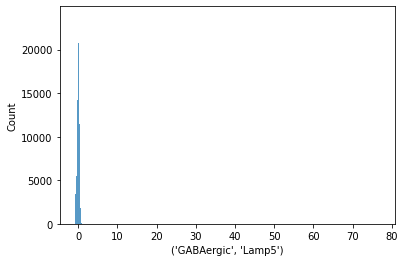

In [100]:
sns.histplot(features.iloc[0])


<Axes: ylabel='Count'>

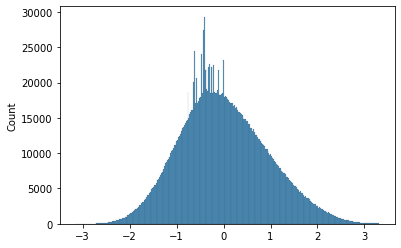

In [86]:
sns.histplot(features_sc[0])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel="('GABAergic', 'Lamp5')">

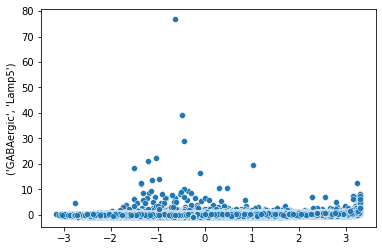

In [99]:
sns.scatterplot(features_sc[0], features.iloc[0])

In [96]:
features_sc[0].shape

(2462755,)

In [98]:
features.iloc[0]

0         -0.785142
1         -0.785142
2         -0.785142
3         -0.785142
4         -0.785142
             ...   
2462750   -0.769360
2462751   -0.769360
2462752   -0.769360
2462753   -0.769360
2462754   -0.769360
Name: (GABAergic, Lamp5), Length: 2462755, dtype: float32

In [93]:
features

0         1         2         3         4        \
classt        group                                                         
GABAergic     Lamp5     -0.785142 -0.785142 -0.785142 -0.785142 -0.785142   
              Pvalb     -0.718649 -0.718649 -0.718649 -0.718649 -0.718649   
              Sncg      -0.751139 -0.751139 -0.751139 -0.751139 -0.751139   
              Sst       -0.779665 -0.779665 -0.779665 -0.779665 -0.779665   
              Sst Chodl -0.652430 -0.652430 -0.652430 -0.652430 -0.652430   
              Vip       -0.774976 -0.774976 -0.774976 -0.774976 -0.774976   
Glutamatergic L2/3 IT   -0.807255 -0.807255 -0.807255 -0.807255 -0.807255   
              L5 IT     -0.716320 -0.716320 -0.716320 -0.716320 -0.716320   
              L5/6 NP   -0.827930 -0.827930 -0.827930 -0.827930 -0.827930   
              L6 CT     -0.786371 -0.786371 -0.786371 -0.786371 -0.786371   
              L6 IT     -0.781564 -0.781564 -0.781564 -0.781564 -0.781564   
              L6b       -0.718809 -0.718809 -0.718809 -0.718809 -0.718809   

                          5         6         7         8         9        \
classt        group                                                         
GABAergic     Lamp5     -0.785142 -0.785142 -0.785142 -0.785142 -0.785142   
              Pvalb     -0.718649 -0.718649 -0.718649 -0.718649 -0.718649   
              Sncg      -0.751139 -0.751139 -0.751139 -0.751139 -0.751139   
              Sst       -0.779665 -0.779665 -0.779665 -0.779665 -0.779665   
              Sst Chodl -0.652430 -0.652430 -0.652430 -0.652430 -0.652430   
              Vip       -0.774976 -0.774976 -0.774976 -0.774976 -0.774976   
Glutamatergic L2/3 IT   -0.807255 -0.807255 -0.807255 -0.807255 -0.807255   
              L5 IT     -0.716320 -0.716320 -0.716320 -0.716320 -0.716320   
              L5/6 NP   -0.827930 -0.827930 -0.827930 -0.827930 -0.827930   
              L6 CT     -0.786371 -0.786371 -0.786371 -0.786371 -0.786371   
              L6 IT     -0.781564 -0.781564 -0.781564 -0.781564 -0.781564   
              L6b       -0.718809 -0.718809 -0.718809 -0.718809 -0.718809   

                         ...   2462745   2462746   2462747   2462748  \
classt        group      ...                                           
GABAergic     Lamp5      ... -0.769360 -0.769360 -0.769360 -0.769360   
              Pvalb      ... -0.714963 -0.714963 -0.714963 -0.714963   
              Sncg       ... -0.746859 -0.746859 -0.746859 -0.746859   
              Sst        ... -0.784999 -0.784999 -0.784999 -0.784999   
              Sst Chodl  ... -0.663325 -0.663325 -0.663325 -0.663325   
              Vip        ... -0.768438 -0.768438 -0.768438 -0.768438   
Glutamatergic L2/3 IT    ... -0.802757 -0.802757 -0.802757 -0.802757   
              L5 IT      ... -0.724596 -0.724596 -0.724596 -0.724596   
              L5/6 NP    ... -0.825276 -0.825276 -0.825276 -0.825276   
              L6 CT      ... -0.789424 -0.789424 -0.789424 -0.789424   
              L6 IT      ... -0.793728 -0.793728 -0.793728 -0.793728   
              L6b        ... -0.716662 -0.716662 -0.716662 -0.716662   

                          2462749   2462750   2462751   2462752   2462753  \
classt        group                                                         
GABAergic     Lamp5     -0.769360 -0.769360 -0.769360 -0.769360 -0.769360   
              Pvalb     -0.714963 -0.714963 -0.714963 -0.714963 -0.714963   
              Sncg      -0.746859 -0.746859 -0.746859 -0.746859 -0.746859   
              Sst       -0.784999 -0.784999 -0.784999 -0.784999 -0.784999   
              Sst Chodl -0.663325 -0.663325 -0.663325 -0.663325 -0.663325   
              Vip       -0.768438 -0.768438 -0.768438 -0.768438 -0.768438   
Glutamatergic L2/3 IT   -0.802757 -0.802757 -0.802757 -0.802757 -0.802757   
              L5 IT     -0.724596 -0.724596 -0.724596 -0.724596 -0.724596   
              L5/6 NP   -0.825276 -0.825276 -0.825276 -0.825276 -0.825276   
            

In [95]:
features_sc.shape

(12, 2462755)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

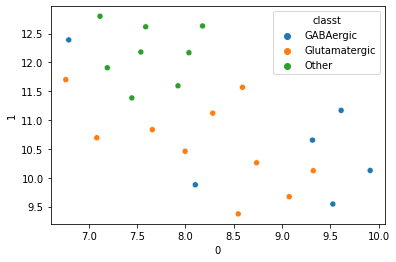

In [321]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

<ipython-input-35-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


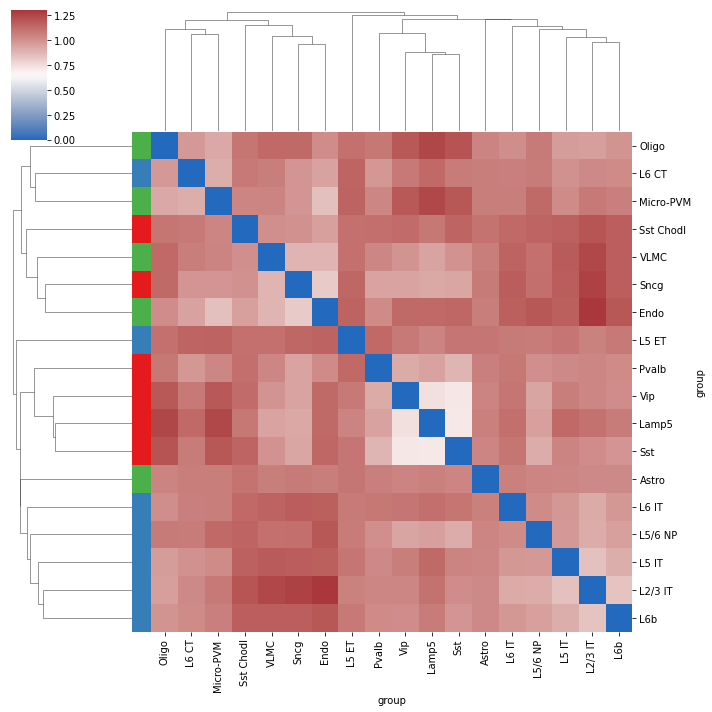

In [35]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-38-6f735b5f1599>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


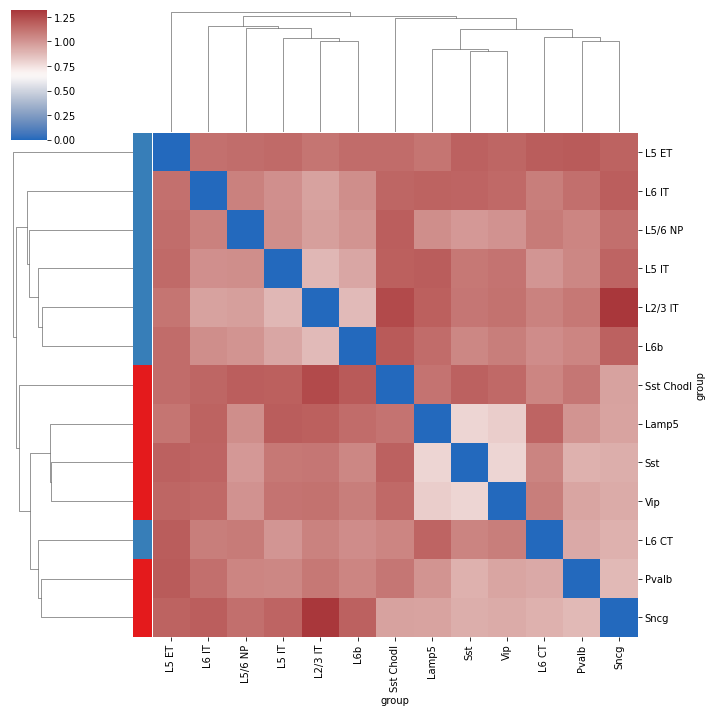

In [38]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

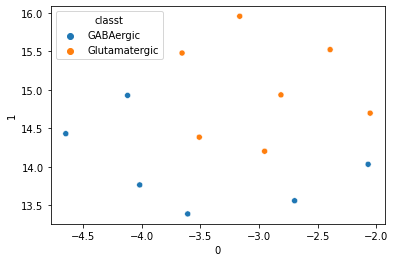

In [40]:
umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [264]:
human_mouse = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.1.bed', sep='\t', names = ['chrm', 'st', 'end', 'human_bin'])


In [265]:
human_mouse

chrm         st        end  human_bin
0        chr6  121508937  121518759          2
1        chr6  121498037  121500284          3
2        chr2  111473169  111475500          5
3        chr2  111476095  111484320          6
4        chr2  111484320  111486136          7
...       ...        ...        ...        ...
210166  chr15   89557076   89570053     287500
210167  chr15   89570053   89575122     287501
210168  chr15   89581917   89584374     287503
210169  chr15   89584374   89588548     287504
210170  chr15   89589547   89591962     287505

[210171 rows x 4 columns]

In [303]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wa -wb -b /grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.5.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > ./dell.bed")
          
          

0

In [295]:
df_human_mouse_com = pd.read_csv("./dell.bed", sep='\t', names = ['chrm', 'st', 'end', 'mouse_bin', 'chrme', 'ste', 'ende', 'human_bin'])



In [306]:
df_human_mouse_com['mouse_bin'].drop_duplicates().tolist()

0            320
2            321
3            322
4            323
5            324
           ...  
133180    246244
133182    246245
133183    246248
133185    246249
133187    246250
Name: mouse_bin, Length: 98690, dtype: int64

In [238]:
df_gene_tp_all_info_mean_group1 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [246]:
df_gene_tp_all_info_mean_group2 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [180]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [23]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, df_human_mouse_com['mouse_bin']]
features = df_gene_tp_all_info_mean.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)




In [292]:
df_gene_tp_all_info_mean.to_csv('./mouse_10.csv')

In [24]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

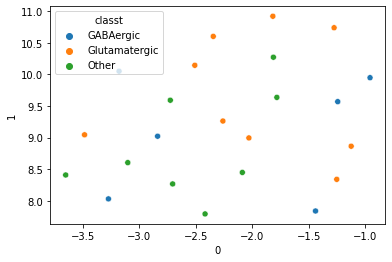

In [25]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

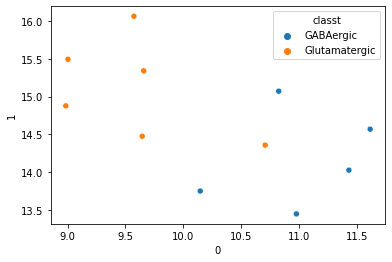

In [23]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [289]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

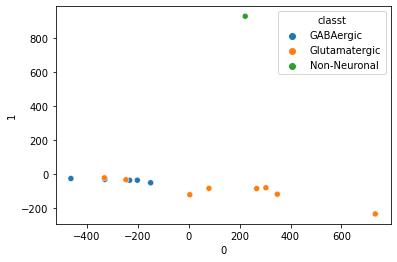

In [290]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [251]:
dj = pd.concat([df_gene_tp_all_info_mean_group1, df_gene_tp_all_info_mean_group2])

dj = dj.reset_index()

dj = dj[dj['classt']=='GABAergic']



from sklearn.decomposition import PCA
features = dj.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=3)
proj_2da = pca.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


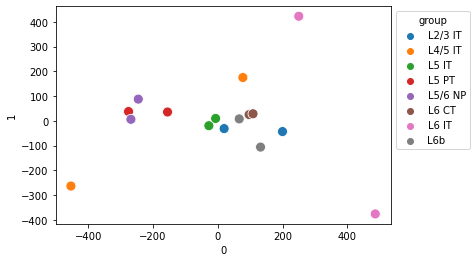

In [250]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


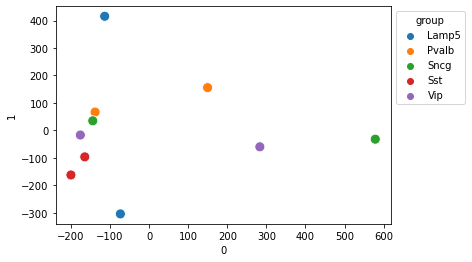

In [252]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-159-9c5bde4097ba>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


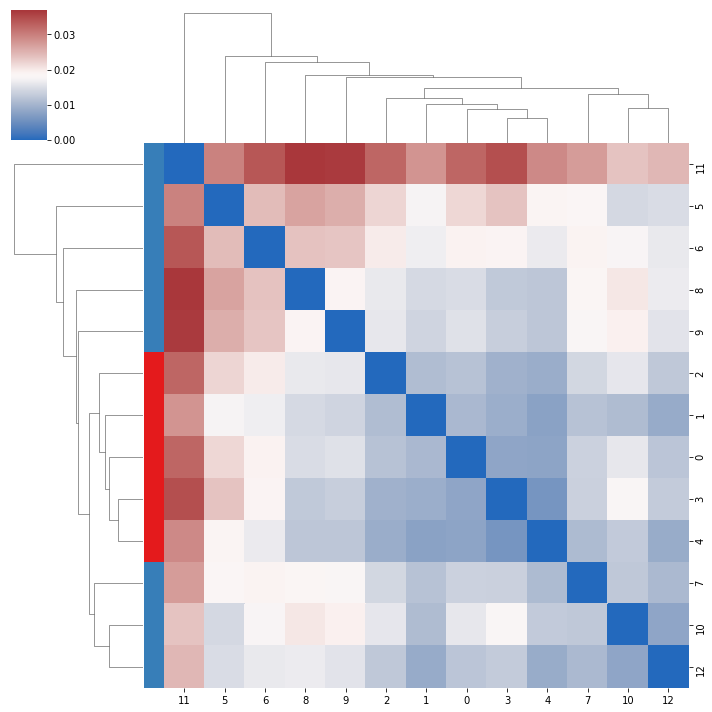

In [159]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-188-33ff0a366977>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


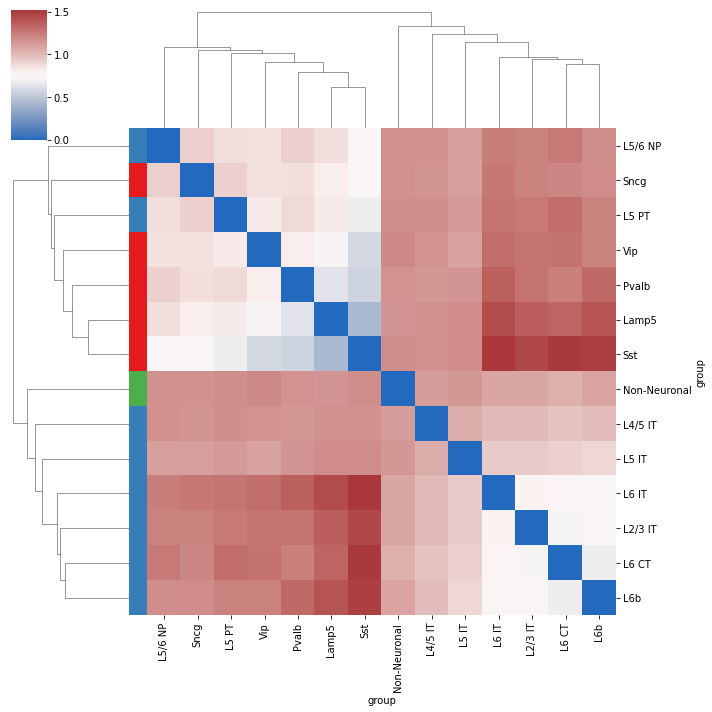

In [188]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [185]:
df_dist.shape

(13, 13)

In [183]:
features.index.get_level_values('group')

Index(['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L5 PT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b', 'Non-Neuronal'],
      dtype='object', name='group')

In [161]:
all_bins_mean.median()

-0.010484438389539719

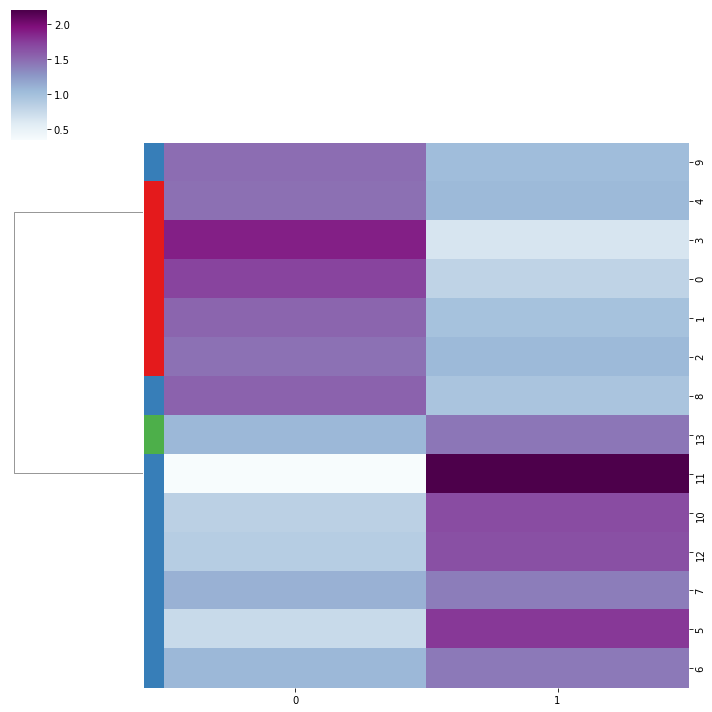

In [148]:
from sklearn.decomposition import NMF



features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
features_sc = abs(features_sc.min()) + features_sc

model = NMF(n_components=2, init='random', random_state=2)
W = model.fit_transform(features_sc)
H = model.components_
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  metric="correlation")



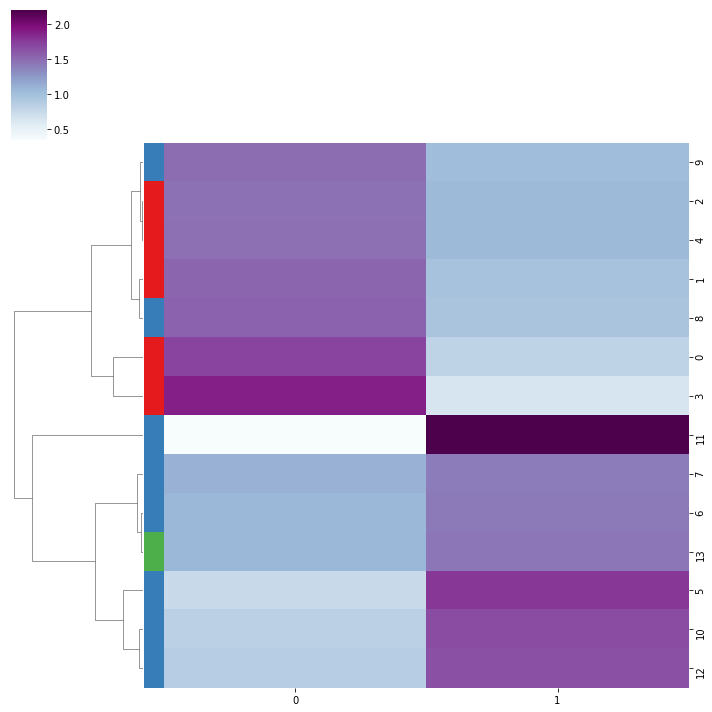

In [149]:
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


<ipython-input-118-ada1e006cb4e>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


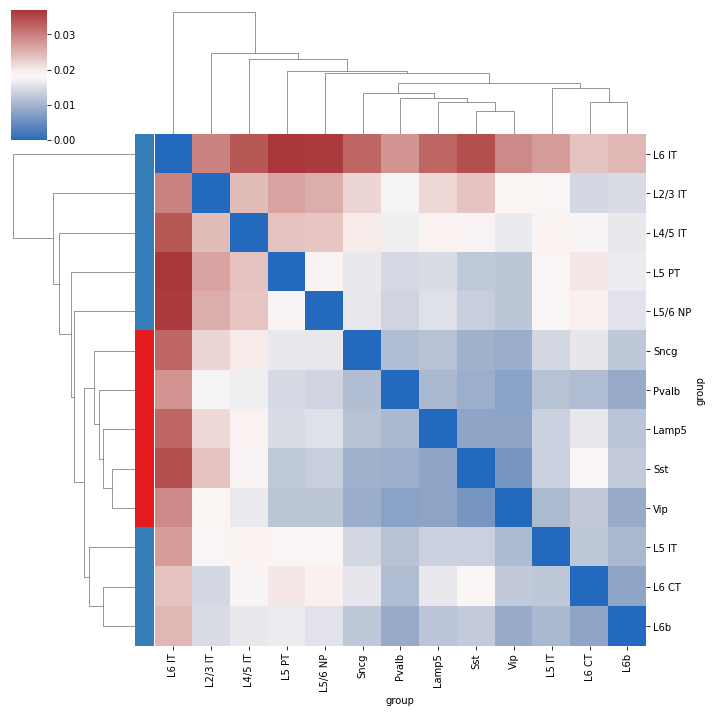

In [118]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


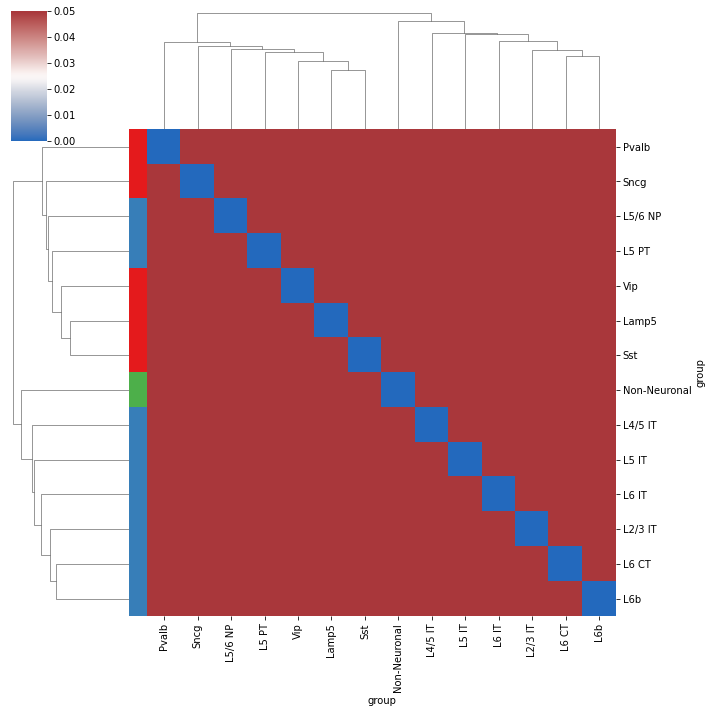

In [145]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=0.05)


In [119]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=df_gene_tp_all_info_mean.index.get_level_values('group'), columns = df_gene_tp_all_info_mean.index.get_level_values('group'))


In [120]:
df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)

(13, 13)
(13, 2)
0.5
0.011834319526627168


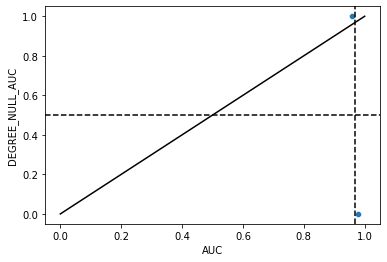

In [121]:

        df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [122]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.958333         6.882918              1.0  0.001025
Glutamatergic  0.977778         6.131162              0.0  0.000209